In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))


In [5]:
missing_values=["N/a", "na", np.nan]
Data = pd.read_csv('/content/dataset1.csv', na_values=(missing_values))
Data.head()

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,Output
0,138,8.6,560,7.46,0.62,0.70,5.9,0.24,0.31,0.77,8.71,0.11,0
1,213,7.5,338,7.62,0.75,1.06,25.4,0.30,0.86,1.54,2.89,2.29,0
2,163,9.6,718,7.59,0.51,1.11,14.3,0.30,0.86,1.57,2.70,2.03,0
3,157,6.8,475,7.64,0.58,0.94,26.0,0.34,0.54,1.53,2.65,1.82,0
4,270,9.9,444,7.63,0.40,0.86,11.8,0.25,0.76,1.69,2.43,2.26,1


In [6]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       880 non-null    int64  
 1   P       880 non-null    float64
 2   K       880 non-null    int64  
 3   pH      880 non-null    float64
 4   EC      880 non-null    float64
 5   OC      880 non-null    float64
 6   S       880 non-null    float64
 7   Zn      880 non-null    float64
 8   Fe      880 non-null    float64
 9   Cu      880 non-null    float64
 10  Mn      880 non-null    float64
 11  B       880 non-null    float64
 12  Output  880 non-null    int64  
dtypes: float64(10), int64(3)
memory usage: 89.5 KB


<Axes: >

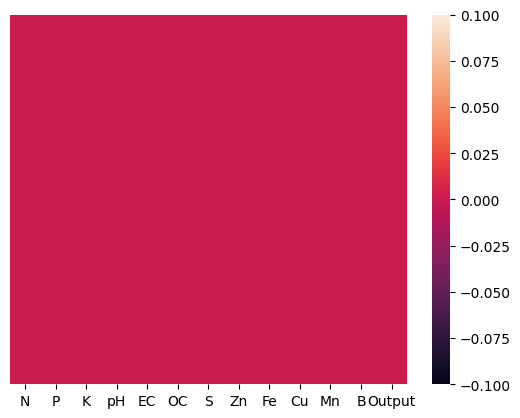

In [7]:
sns.heatmap(Data.isnull(), yticklabels=False)

In [8]:
Data.duplicated().sum()

0

In [9]:
Data.describe()

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,Output
count,880.00000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,246.73750,14.562159,499.978409,7.510500,0.543659,0.617989,7.545080,0.469273,4.140523,0.952443,8.666500,0.590159,0.588636
std,77.38886,21.967755,124.222838,0.464912,0.141597,0.842986,4.424184,1.894234,3.110011,0.465900,4.298828,0.570800,0.575462
min,6.00000,2.900000,11.000000,0.900000,0.100000,0.100000,0.640000,0.070000,0.210000,0.090000,0.110000,0.060000,0.000000
25%,201.00000,6.800000,412.000000,7.350000,0.430000,0.380000,4.700000,0.280000,2.050000,0.630000,6.225000,0.270000,0.000000
50%,257.00000,8.100000,475.000000,7.500000,0.545000,0.590000,6.640000,0.360000,3.565000,0.930000,8.345000,0.405000,1.000000
75%,307.00000,10.550000,581.000000,7.630000,0.640000,0.780000,8.750000,0.470000,6.320000,1.250000,11.472500,0.610000,1.000000
max,383.00000,125.000000,887.000000,11.150000,0.950000,24.000000,31.000000,42.000000,44.000000,3.020000,31.000000,2.820000,2.000000


In [10]:
from sklearn.utils import resample

class_0 = Data[Data['Output'] == 0]
class_1 = Data[Data['Output'] == 1]
class_2 = Data[Data['Output'] == 2]

class_2_oversampled = resample(class_2,
                               replace=True,
                               n_samples=200,
                               random_state=42)

oversampled_data = pd.concat([class_0, class_1, class_2_oversampled])
Data = oversampled_data

<Axes: >

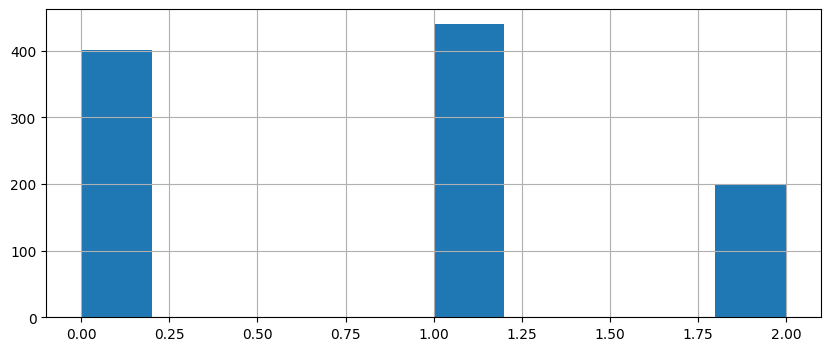

In [11]:
Data['Output'].hist(figsize=(10, 4))

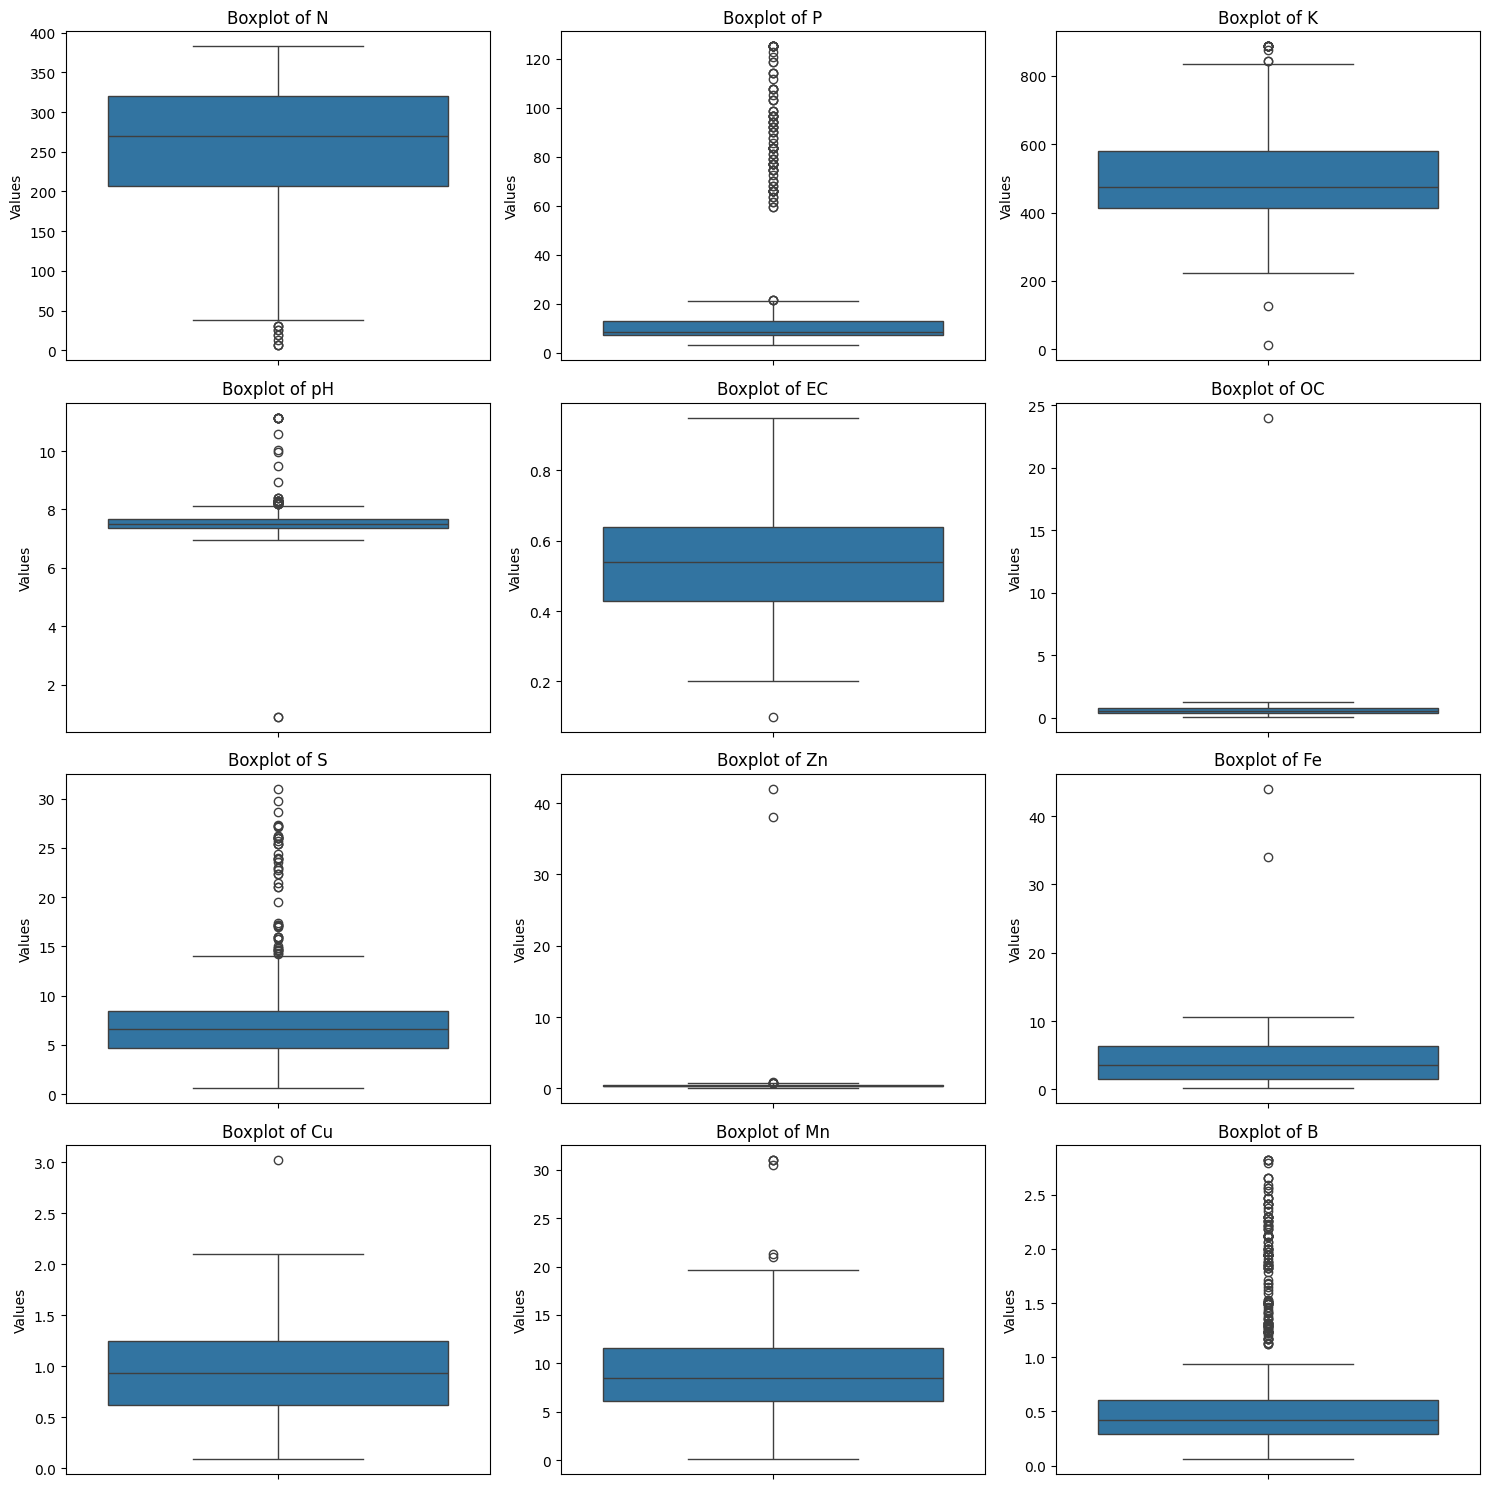

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(Data.columns):
  if column == 'Output':
    continue
  sns.boxplot(data=Data[column], ax=axes[i])
  axes[i].set_title(f'Boxplot of {column}')
  axes[i].set_xlabel('')
  axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

In [18]:
Q1 = Data.quantile(0.25)
Q3 = Data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_features = Data[~((Data < lower_bound) | (Data > upper_bound)).any(axis=1)]

print("Original shape:", Data.shape)
print("Shape after removing outliers:", filtered_features.shape)

Original shape: (1041, 13)
Shape after removing outliers: (716, 13)


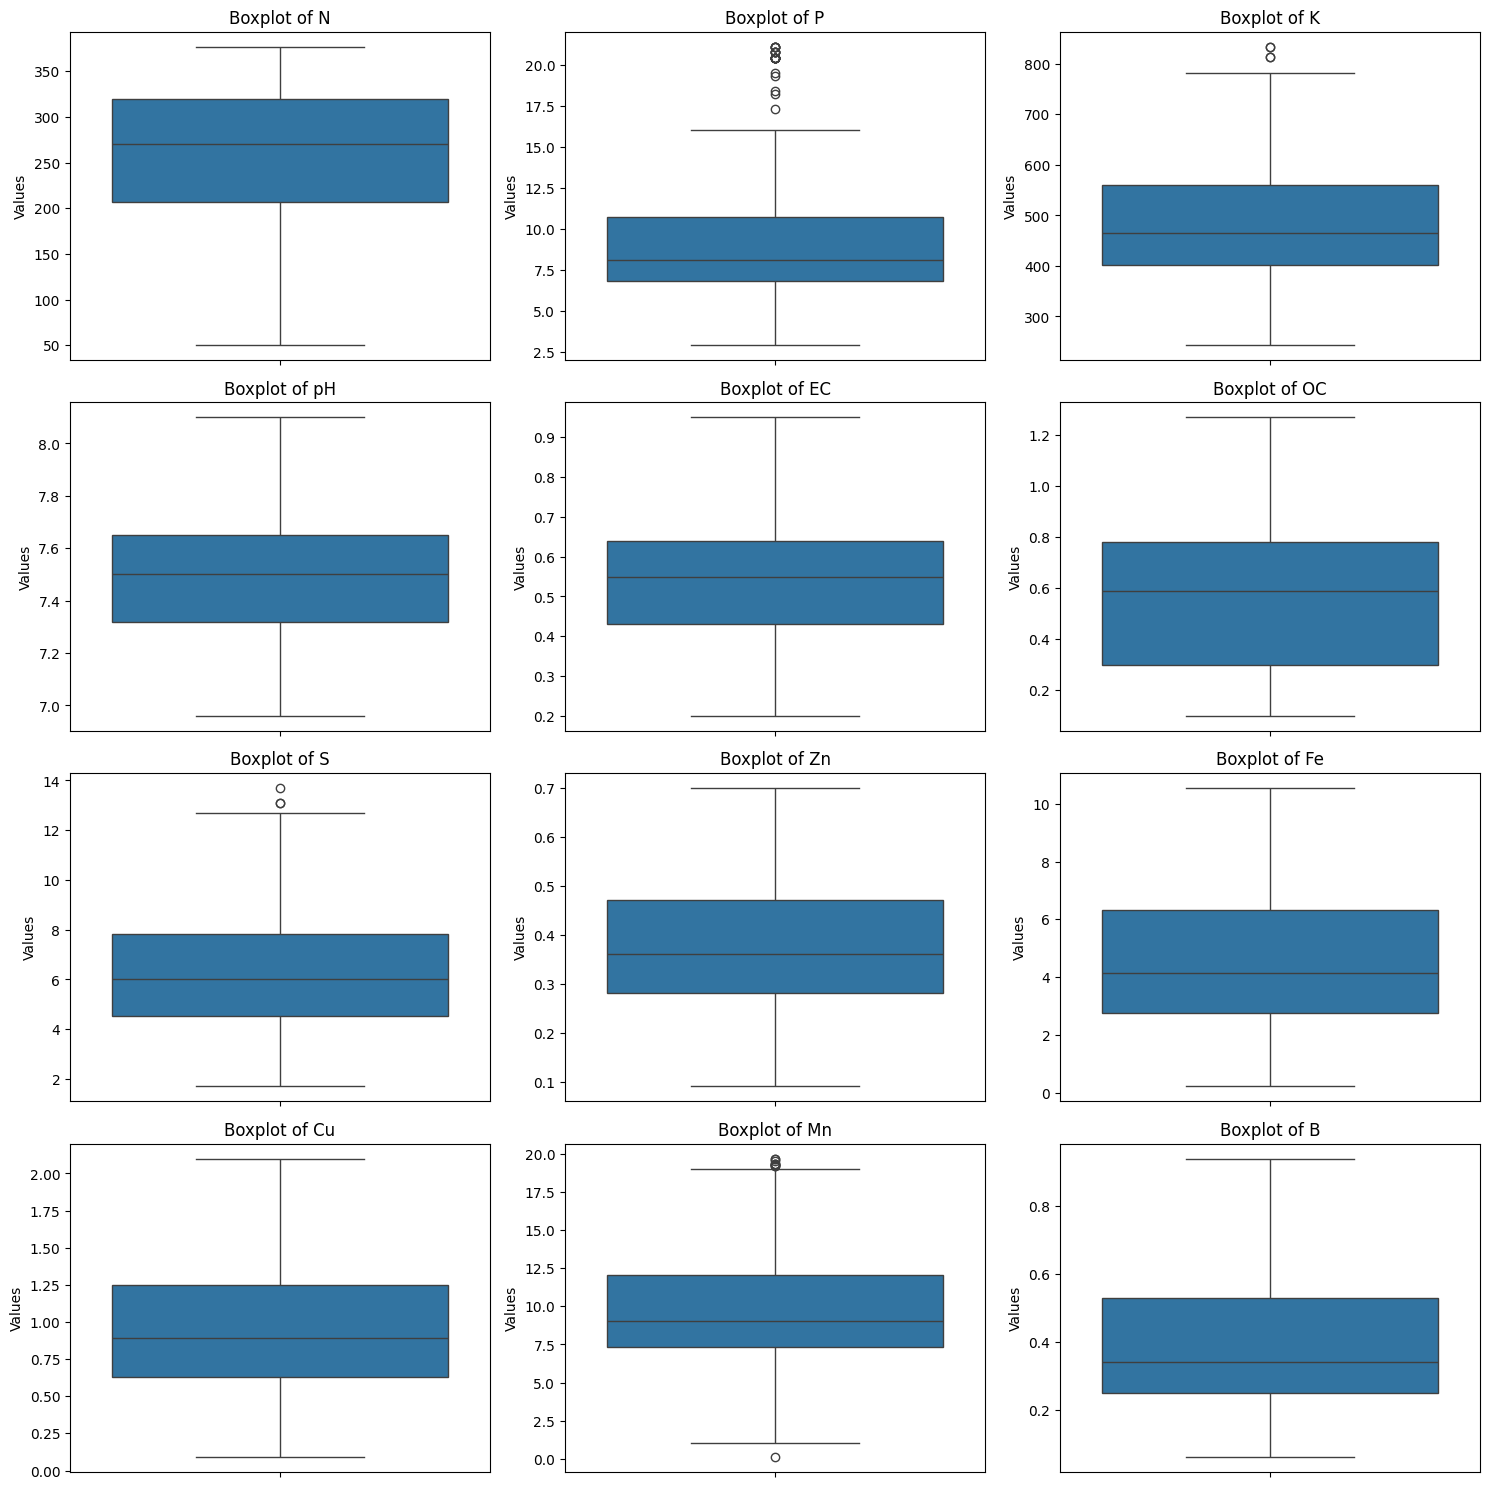

In [20]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
for i, column in enumerate(filtered_features.columns):
  if column == 'Output':
    continue
  sns.boxplot(data=filtered_features[column], ax=axes[i])
  axes[i].set_title(f'Boxplot of {column}')
  axes[i].set_xlabel('')
  axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

In [21]:
labels = filtered_features[['Output']]
features = filtered_features.drop('Output', axis=1)

In [22]:
print(f"Features Shape: {features.shape}")
print(f"Labels Shape: {labels.shape}")

Features Shape: (716, 12)
Labels Shape: (716, 1)


<Axes: >

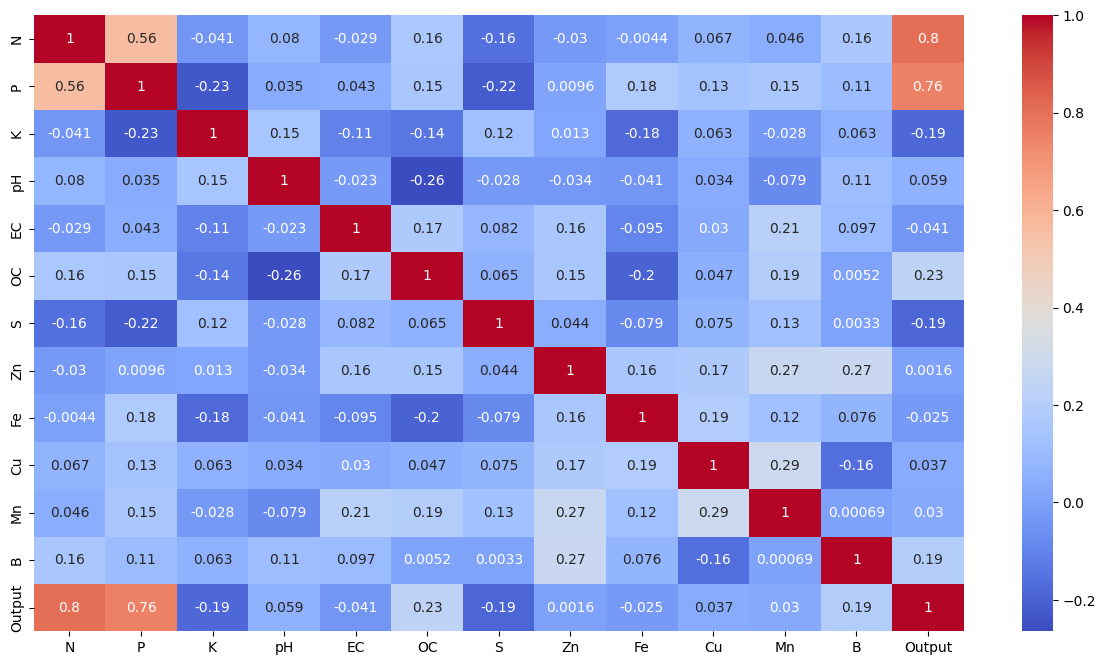

In [23]:
plt.figure(figsize=(15, 8))
sns.heatmap(features.join(labels).corr(), annot=True, cmap='coolwarm')

In [24]:
features.var()

,0
N,5146.512207
P,12.153910
K,12126.570135
pH,0.063922
EC,0.019929
OC,0.096161
S,5.223278
Zn,0.013422
Fe,5.837588
Cu,0.185546


In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_features_df.head()

,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B
0,0.269113,0.313187,0.536379,0.438596,0.560000,0.512821,0.350000,0.245902,0.009671,0.338308,0.439224,0.056818
1,0.596330,0.285714,0.536379,0.307018,0.573333,0.581197,0.825000,0.327869,0.021277,0.238806,0.389173,0.772727
2,0.596330,0.296703,0.536379,0.543860,0.720000,0.623932,0.541667,0.377049,0.072534,0.736318,0.130746,0.602273
3,0.174312,0.296703,0.624365,0.412281,0.306667,0.555556,0.458333,0.147541,0.071567,0.398010,0.104699,0.772727
4,0.461774,0.131868,0.446701,0.561404,0.440000,0.247863,0.763333,0.377049,0.881044,0.298507,0.455567,0.715909


In [26]:
scaled_features_df.var()

,0
N,0.048130
P,0.036692
K,0.034719
pH,0.049186
EC,0.035429
OC,0.070247
S,0.036273
Zn,0.036070
Fe,0.054600
Cu,0.045926


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

Input, testInput, Target, testTarget = train_test_split(scaled_features_df, labels, test_size = 0.2, shuffle=True, random_state= 42)
trainInput, validationInput, trainTarget, validationTarget = train_test_split(Input, Target, test_size = 0.2, shuffle=True, random_state=42)

In [29]:
print("Training input shape:", trainInput.shape)
print("Validation input shape:", validationInput.shape)
print("Test input shape:", testInput.shape)

Training input shape: (457, 12)
Validation input shape: (115, 12)
Test input shape: (144, 12)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import SGD

weight_initialization = initializers.HeNormal()
model = Sequential([Input(shape=(12,)),
                    Dense(64, activation='relu', kernel_initializer=weight_initialization),
                    Dense(32, activation='relu', kernel_initializer=weight_initialization),
                    Dense(16, activation='relu', kernel_initializer=weight_initialization),
                    Dense(3, activation='softmax')])

model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
checkpoint_callback = ModelCheckpoint(
    'best_weights.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    trainInput, trainTarget,
    validation_data=(validationInput, validationTarget),
    epochs = 100,
    batch_size= 32,
    callbacks=[checkpoint_callback],
    verbose=1
)
model.summary()

Epoch 1/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 11s 805ms/step - accuracy: 0.0938 - loss: 1.5935
Epoch 1: val_loss improved from inf to 1.14866, saving model to best_weights.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2190 - loss: 1.3515 - val_accuracy: 0.4174 - val_loss: 1.1487
Epoch 2/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3438 - loss: 1.1005
Epoch 2: val_loss improved from 1.14866 to 1.04625, saving model to best_weights.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4716 - loss: 1.0217 - val_accuracy: 0.5826 - val_loss: 1.0462
Epoch 3/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7812 - loss: 0.7959
Epoch 3: val_loss improved from 1.04625 to 0.95615, saving model to best_weights.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6928 - loss: 0.8903 - val_accuracy: 0.7130 - val_loss: 0.9562
Epoch 4/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8125 - loss: 0.7972
Epoch 4: val_loss improved from 0.95615 to 0.88711,

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,984 (27.29 KB)

 Trainable params: 3,491 (13.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,493 (13.65 KB)

In [35]:
model.load_weights('best_weights.keras')
loss, accuracy = model.evaluate(testInput, testTarget, verbose=0)
print(f"test Accuracy: {accuracy:.2f}")

test Accuracy: 0.88


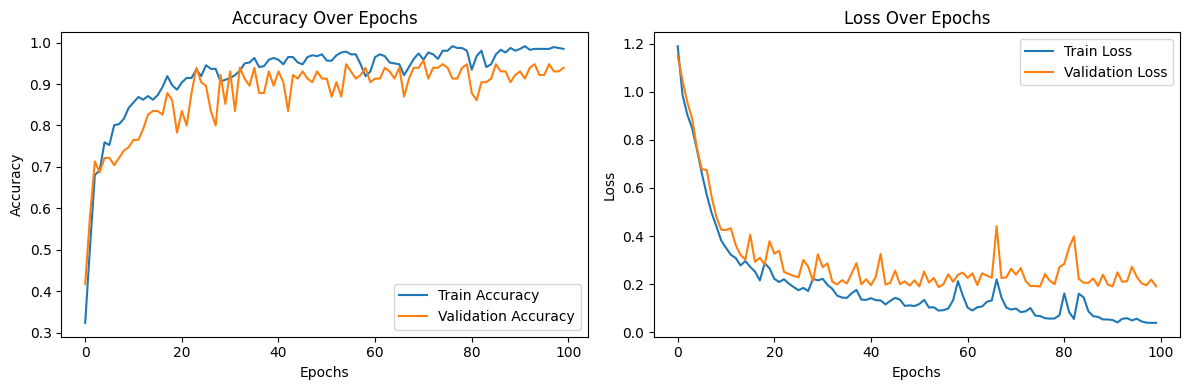

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

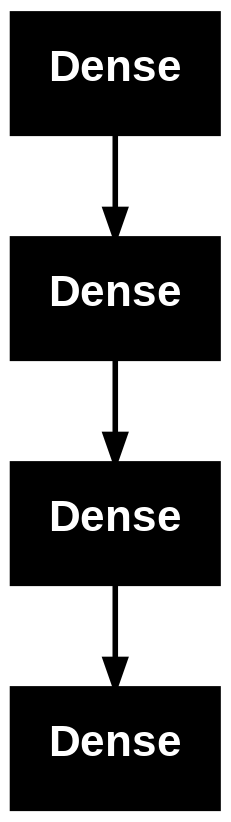

In [38]:
from keras.utils import plot_model
from keras.models import load_model
plot_model(model, to_file='model_architecture.png',show_shapes=False)

In [39]:
model.save('model.h5')

In [40]:
import pickle
with open('history.pkl', 'wb') as file:
  pickle.dump(history.history, file)

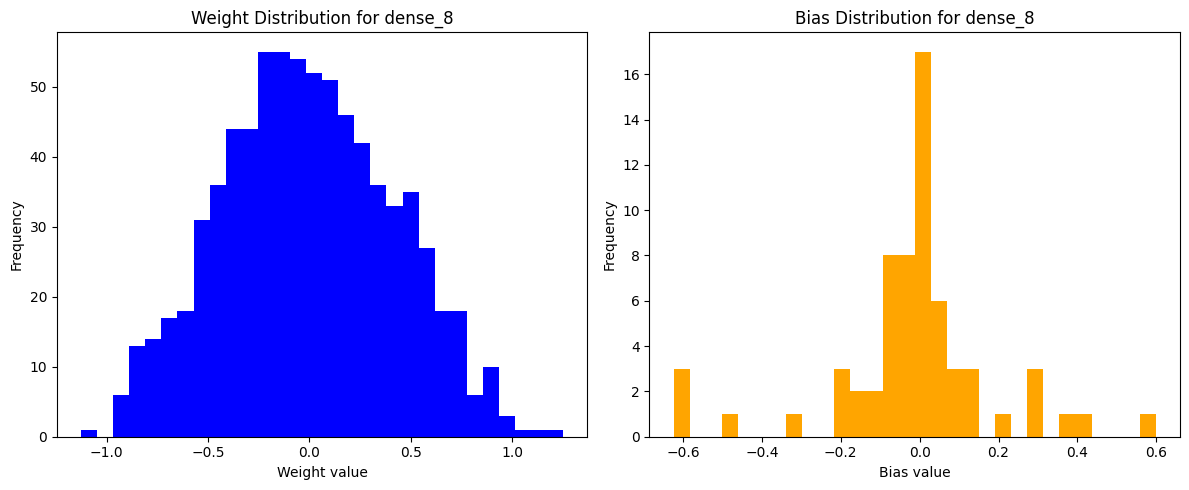

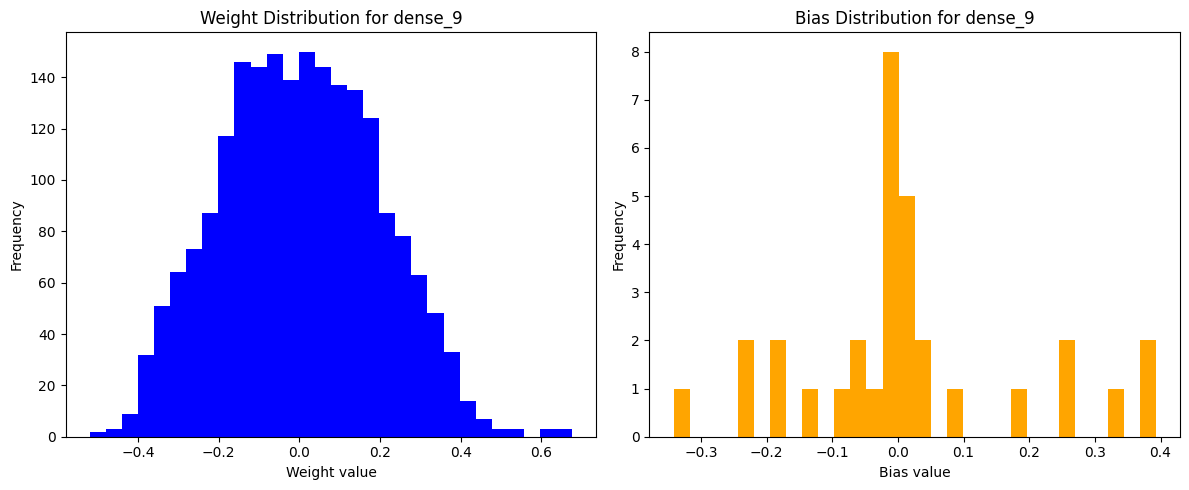

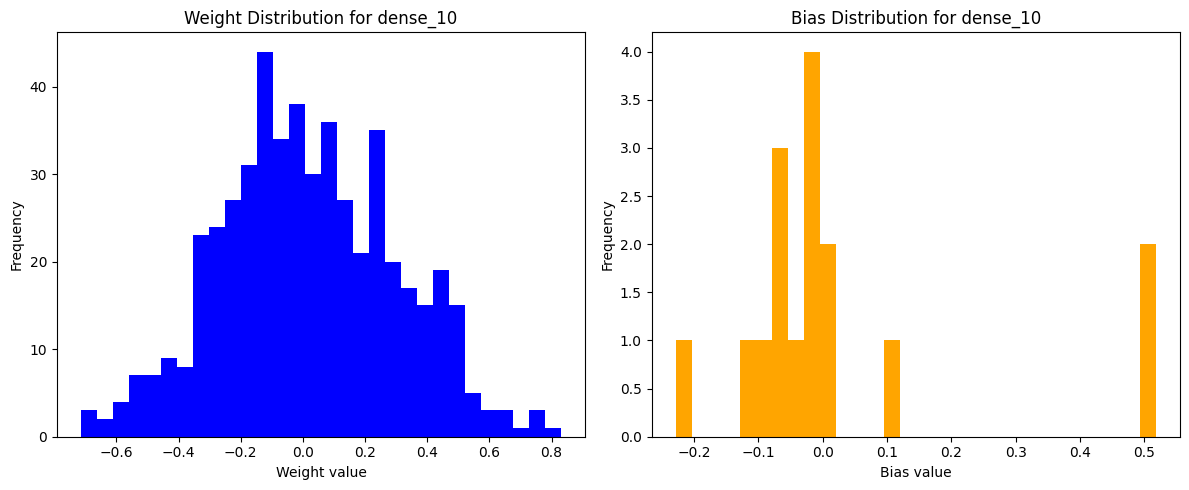

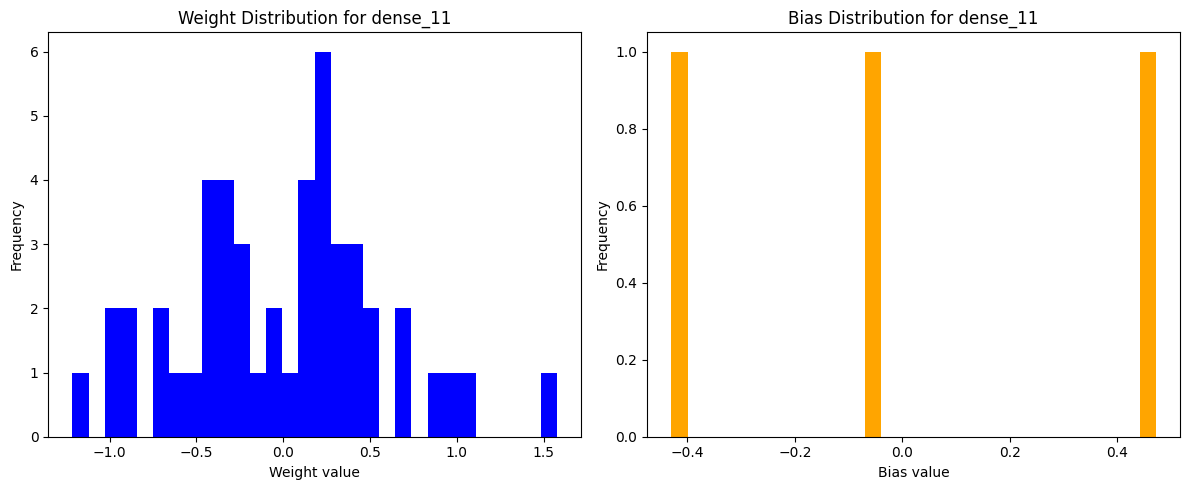

In [41]:
for layer in model.layers:
  weights, biases = layer.get_weights()
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.hist(weights.flatten(), bins=30, color='blue')
  plt.title(f"Weight Distribution for {layer.name}")
  plt.xlabel("Weight value")
  plt.ylabel("Frequency")

  plt.subplot(1, 2, 2)
  plt.hist(biases.flatten(), bins=30, color='orange')
  plt.title(f"Bias Distribution for {layer.name}")
  plt.xlabel("Bias value")
  plt.ylabel("Frequency")

  plt.tight_layout()
  plt.show()

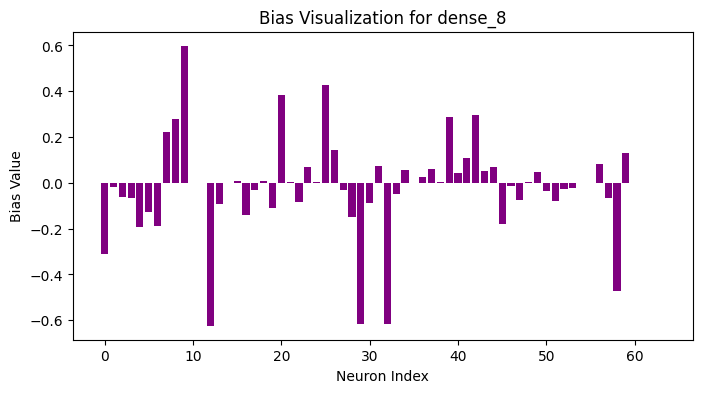

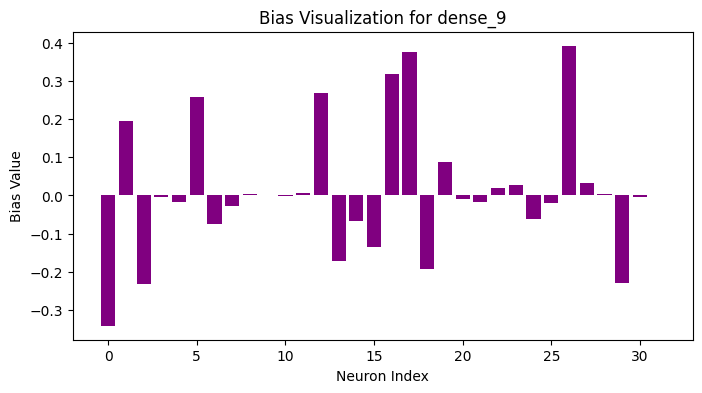

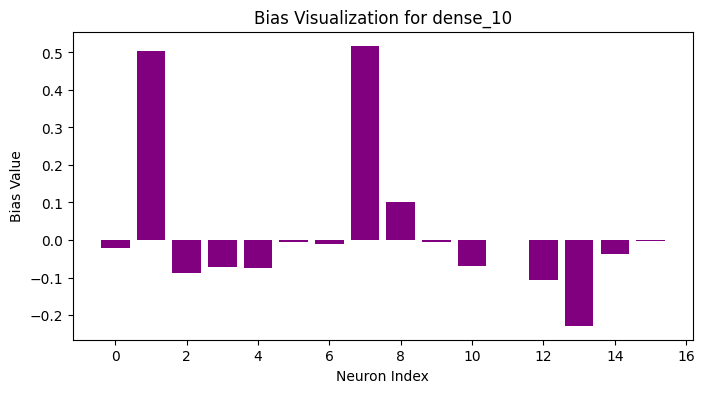

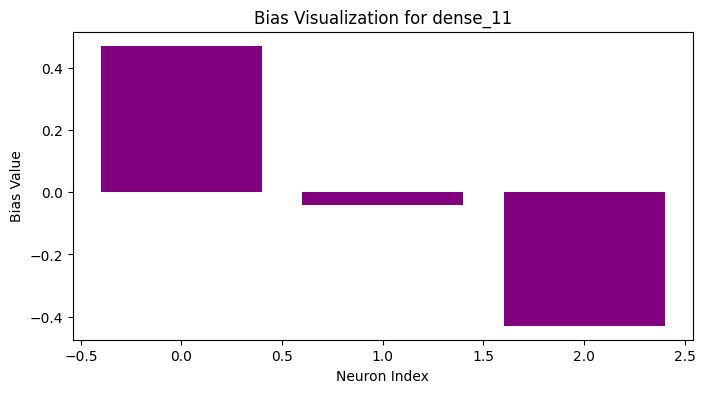

In [42]:
for layer in model.layers:
  _, biases = layer.get_weights()
  plt.figure(figsize=(8, 4))
  plt.bar(range(len(biases)), biases, color='purple')
  plt.title(f"Bias Visualization for {layer.name}")
  plt.xlabel("Neuron Index")
  plt.ylabel("Bias Value")
  plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 0/15 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

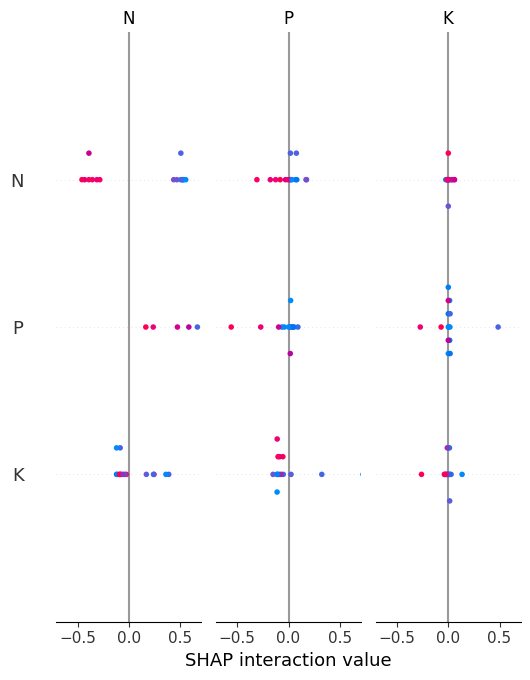

In [43]:
import shap

explainer = shap.KernelExplainer(model.predict, trainInput)
shap_values = explainer.shap_values(testInput[:15], nsamples=100)
shap.summary_plot(shap_values, testInput[:15])

In [45]:
from keras.models import load_model

def get_model(path):
  pretrained_model = load_model(path)
  return pretrained_model

In [47]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


In [54]:
from keras_tuner import HyperParameters
import tensorflow as tf
import os

# Use the correct path where the model was saved
# You may need to adjust this path based on where you saved your model previously
path = 'model.h5'  # Update this if necessary

# Removing the check for the model as it has already been saved in a previous cell.
# if not os.path.exists(path):
#   raise ValueError(f"Model file not fount at {path}. Please make sure to save the model before attempting to load it.")


def model_with_hp(hp):
  fine_tuned_model = get_model(path)

  fine_tuned_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 2e-2, sampling='LOG')),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  return fine_tuned_model

In [55]:
from keras_tuner import Hyperband

tuner = Hyperband(
    model_with_hp,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_result',
    project_name='hyperparameter_tuning'
)

In [56]:
tuner.search(trainInput, trainTarget, epochs=5, validation_data=(validationInput, validationTarget), batch_size=32)

Trial 30 Complete [00h 00m 04s]
val_accuracy: 0.95652174949646

Best val_accuracy So Far: 0.95652174949646
Total elapsed time: 00h 01m 51s


In [57]:
tuner.results_summary()

Results summary
Results in tuner_result/hyperparameter_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0019 summary
Hyperparameters:
learning_rate: 0.012925360866291275
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.95652174949646

Trial 0029 summary
Hyperparameters:
learning_rate: 0.002808057731484277
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.95652174949646

Trial 0000 summary
Hyperparameters:
learning_rate: 0.0007158000302516951
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.947826087474823

Trial 0003 summary
Hyperparameters:
learning_rate: 0.00019071538372142778
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.947826087474823

Trial 0004 summary
Hyperparameters:
learning_rate: 0.00028192428464246446
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.947826087474823

Trial 0012 summar

In [58]:
best_model = tuner.get_best_models(num_models=1)[0]

test_loss, test_acc = best_model.evaluate(testInput, testTarget)
print(f"Test Accuracy: {test_acc}")

best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters:", best_hyperparameters.values)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8927 - loss: 0.3543  
Test Accuracy: 0.8888888955116272
Best Hyperparameters: {'learning_rate': 0.012925360866291275, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
